# <center>Quantium Virtual Internship<BR>Retail Strategy and Analytics<BR>Task 2</center>

## Description of Analyses

Stores 76, 86, 88 were selected for a trial layout of a new chips category which commenced at the beginning of February 2019 and concluded at the end of April 2019. To determine whether this trial was a success, comparisons need to be made with other stores with sales during the same time period. To achieve this, a control store with similar sales and numbers of customers per month in the pre-trial period will be selected for each trial store. Total sales and number of customers per month will then be compared in the trial period to determine if each trial store deviates from the control store.

## Import Packages

In [1]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
from datetime import date
from scipy.stats import pearsonr, t
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Create Dataframe from Data File

In [2]:
data = pd.read_csv('QVI_data.csv')

## Create Additional Feature

In [3]:
# Create new column containing just the year and month
data['YEARMONTH'] = pd.to_datetime(data['DATE']).dt.to_period('M')

## Create Dataframes with Measure Calculations for Analysis

### Dataframe with Measure Calculations for All Stores

The dataframe includes the following measures by month for each store:
- Total sales
- Number of customers
- Average price per unit sold
- Average number of transactions per customer
- Average number of chips per customers

**NB**: Only the first two measures will be used in this analysis


In [4]:
measure_over_time = (data.groupby(['STORE_NBR','YEARMONTH']).agg(
    Tot_Sales = pd.NamedAgg(column='TOT_SALES', aggfunc='sum'),
    Number_Customers = pd.NamedAgg(column='LYLTY_CARD_NBR', aggfunc='nunique'),
    Number_Txns = pd.NamedAgg(column='TXN_ID', aggfunc='count'),
    Number_Chips = pd.NamedAgg(column='PROD_QTY', aggfunc='sum'),
    Avg_Price_Per_Unit = pd.NamedAgg(column='UNIT_PRICE',
                                     aggfunc='mean'))).reset_index()
                     
measure_over_time['Avg_Txn_Per_Cust'] = measure_over_time['Number_Txns'] / \
                                         measure_over_time['Number_Customers']
measure_over_time['Avg_Chips_Per_Txn'] = measure_over_time['Number_Chips'] / \
                                          measure_over_time['Number_Txns']
measure_over_time.drop(columns=['Number_Txns', 'Number_Chips'], inplace=True)

### Filter Dataframe to Stores with Sales in All Months of the Pre-Trial Period

The dataframe excludes stores that did not have sales in each month of the financial year. It also only includes months in the pre-trial period.

In [5]:
stores_month_count = measure_over_time.groupby(['STORE_NBR']).agg(
    Count = pd.NamedAgg(column='YEARMONTH', aggfunc='count'))
stores_with_full_obs = [int(index)
                        for index, row in stores_month_count.iterrows()
                        if row['Count'] == 12]
pre_trial_measures = measure_over_time[measure_over_time.YEARMONTH < '2019-02']
pre_trial_measures = pre_trial_measures[pre_trial_measures.STORE_NBR.
                                        isin(stores_with_full_obs)]

## Functions Required for Analysis

In [6]:
def calculate_correlation(df, metric_col, store_comparison):
    """
    Creates a new dataframe with correlations for a chosen metric between a
    selected trial store and all remaining stores. The correlations are used
    to help determine which store is most similar to the trial store.
    """
    store1 = df[df.STORE_NBR == store_comparison][metric_col]
    df = df[df.STORE_NBR != store_comparison]
    calculated_measure = []
    for number in df.STORE_NBR.unique():
        store2 = df[df.STORE_NBR == number][metric_col]
        corr, _ = pearsonr(store1, store2)
        calculated_measure.append([store_comparison, number, corr])
    
    calc_corr_table = pd.DataFrame(calculated_measure)
    calc_corr_table.columns = ['Trial_Store', 'Control_Stores', 'Correlation']
    return calc_corr_table

In [7]:
def calculate_magnitude_distance(df, metric_col, store_comparison):
    """
    Creates a new dataframe with standardized differences for a chosen metric
    between a selected trial store and each of the remaining stores. The
    calculated difference is used to help determine which store is most
    similar to the trial store.
    """
    calculated_measure = []
    for number in df.STORE_NBR.unique():
        for date in df.YEARMONTH.unique():
            distance1 = df[(df.YEARMONTH == date) &
                           (df.STORE_NBR == number)][metric_col]
            distance2 = df[(df.YEARMONTH == date) &
                           (df.STORE_NBR == store_comparison)][metric_col]
            calculated_measure.append([store_comparison,
                                       number,
                                       date,
                                       abs(float(distance1) -
                                           float(distance2))])
    
    calc_dist_table = pd.DataFrame(calculated_measure)
    calc_dist_table.columns = ['Trial_Store',
                               'Control_Stores',
                               'YEARMONTH',
                               'Measure']
    calc_dist_table = calc_dist_table[calc_dist_table.Control_Stores !=
                                      store_comparison]
    std_measure = pd.DataFrame(1 - (calc_dist_table.Measure -
                                    min(calc_dist_table.Measure)) / 
                               (max(calc_dist_table.Measure -
                                    min(calc_dist_table.Measure))))
    std_measure.columns = ['Std_Measure']
    calc_dist_table = calc_dist_table.join(std_measure, how='outer')
    calc_dist_table.drop(columns=['Measure'], inplace=True)
    return calc_dist_table.groupby(['Trial_Store',
                                    'Control_Stores']).agg({'Std_Measure':
                                                            'mean'}). \
                                                             reset_index()

In [8]:
def best_control_store(corr_measure1,
                       corr_measure2,
                       dist_measure1,
                       dist_measure2,
                       corr_weight):
    """
    Uses a combination of measures to create a composite score to determine
    which store is most similar to the trial store.
    """
    sales_scores = pd.merge(corr_measure1,
                            dist_measure1,
                            how='left',
                            left_on=['Trial_Store','Control_Stores'],
                            right_on = ['Trial_Store','Control_Stores'])
    sales_scores['Sales_Scores'] = \
                            (abs(corr_measure1.Correlation)*corr_weight) + \
                            (dist_measure1.Std_Measure*corr_weight)
    
    customers_scores = pd.merge(corr_measure2,
                                dist_measure2,
                                how='left',
                                left_on=['Trial_Store','Control_Stores'],
                                right_on = ['Trial_Store','Control_Stores'])
    customers_scores['Customers_Scores'] = \
                                (abs(corr_measure2.Correlation)*corr_weight) + \
                                (dist_measure2.Std_Measure*corr_weight)
    
    total_score = pd.merge(sales_scores, customers_scores,
                           how='left',
                           left_on=['Trial_Store','Control_Stores'],
                           right_on = ['Trial_Store','Control_Stores'])
    total_score['Total_Score'] = \
                            (sales_scores.Sales_Scores*corr_weight) + \
                            (customers_scores.Customers_Scores*corr_weight)
    
    best_store = total_score.sort_values(by='Total_Score',
                                         ascending=False).Control_Stores.iloc[0]
    return best_store

In [9]:
def add_store_type(df, date, trial, control):
    """
    Adds a column to a dataframe that labels, the selected trial and control
    store with these names repectively. All other stores are labelled
    'Other stores'.
    """
    df = df[df.YEARMONTH < date]
    df['Store_type'] = ['Trial' if store == trial else
                        'Control' if store == control else
                        'Other stores' for store in df.STORE_NBR]
    return df

In [10]:
def plot_total_sales_by_month(df):
    """
    Plots total sales by month for each store type.
    """
    sns.set(rc={'figure.figsize':(10,6)})
    sns.lineplot(data=df, x='YEARMONTH', y='Tot_Sales', hue='Store_type')
    plt.xlabel('Month of Operation', fontsize = 20)
    plt.xticks(fontsize=15, rotation=70)
    plt.ylabel('Total Sales', fontsize = 20)
    plt.yticks(fontsize=15)
    plt.title('Total Sales by Month', fontsize = 22)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [11]:
def plot_number_of_customers_by_month(df):
    """
    Plots number of customers by month for each store type.
    """
    sns.set(rc={'figure.figsize':(10,6)})
    sns.lineplot(data=df, x='YEARMONTH', y='Number_Customers', hue='Store_type')
    plt.xlabel('Month of Operation', fontsize = 20)
    plt.xticks(fontsize=15, rotation=70)
    plt.ylabel('Number of Customers', fontsize = 20)
    plt.yticks(fontsize=15)
    plt.title('Number of Customers by Month', fontsize = 22)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [12]:
def scale_control_metric(pre_trial_df, full_df, trial, control, metric_col):
    """
    Returns a dataframe with the metric of the control store scaled in
    proportion to the trial store. The scaling is based only on values in
    the pre-trial period. This is required for a more accurate comparison.
    """
    scaling_factor_control_metric = \
                                sum(pre_trial_df[pre_trial_df.STORE_NBR ==
                                                 trial_store][metric_col]) / \
                                sum(pre_trial_df[pre_trial_df.STORE_NBR ==
                                                 control_store][metric_col])
    scaled_control_metric = full_df[full_df.STORE_NBR == control_store]
    scaled_control_metric['Control_Metric'] = \
                                        scaled_control_metric[metric_col] * \
                                        scaling_factor_control_metric
    return scaled_control_metric

In [13]:
def calculate_perc_diff(scaled_df, full_df, trial, metric_col):
    """
    Returns a dataframe with a calculation of the percentage difference between
    a scaled control metric and the same metric for a trial store.
    """
    control_metric = scaled_df[['YEARMONTH','Control_Metric']]
    trial_metric = full_df[full_df.STORE_NBR == trial][['YEARMONTH',metric_col]]
    perc_diff = pd.merge(control_metric,
                          trial_metric,
                          how='left',
                          left_on=['YEARMONTH'],
                          right_on = ['YEARMONTH'])
    perc_diff.rename(columns={metric_col: 'Trial_Metric'}, inplace=True)
    perc_diff['Percent_Diff'] = (perc_diff.Control_Metric -
                                  perc_diff.Trial_Metric) / \
                                  ((perc_diff.Control_Metric +
                                    perc_diff.Trial_Metric)/2)
    return perc_diff

In [14]:
def calculate_std_dev_mean(df):
    """
    Returns a standard deviation and mean for the calculated percentage
    difference of the required metric across the months in the pre-trial
    period.
    """
    std_dev = df[df.YEARMONTH < '2019-02']['Percent_Diff'].std()
    u = df[df.YEARMONTH < '2019-02']['Percent_Diff'].mean()
    return std_dev, u

In [15]:
def calculate_t_values(df, std_dev, u):
    """
    Returns a dataframe with a t-value statistic for the percentage
    differences between the scaled control metric and the same metric for the
    trial store.
    """
    df['T-Value'] = abs((df.Percent_Diff - u) / std_dev)
    return df

In [16]:
def create_control_trial_dataframe(df, trial, control):
    """
    Returns a datframe that only contains monthly values for the control and
    trial store over the entire financial year.
    """
    df['Store_type'] = ['Trial' if store == trial else
                        'Control' if store == control else
                        None for store in df.STORE_NBR]
    df['YEARMONTH'] = df['YEARMONTH'].astype(str)
    df = df[(df.Store_type == 'Control') | (df.Store_type == 'Trial')]
    return df

In [17]:
def control_conf_int(df, metric_col):
    """
    Returns a dataframe that adds a 5th and 95th confidence interval for the
    control store metric for each month.
    """
    df_Controls95 = df[df.Store_type == 'Control']
    df_Controls95[metric_col] = df_Controls95[metric_col] * (1 + std_dev * 2)
    df_Controls95.loc[:, 'Store_type'] = 'Control 95th % confidence interval'
    
    df_Controls5 = df[df.Store_type == 'Control']
    df_Controls5[metric_col] = df_Controls5[metric_col] * (1 - std_dev * 2)
    df_Controls5.loc[:, 'Store_type'] = 'Control 5th % confidence interval'
    return pd.concat([df, df_Controls95, df_Controls5])

## Analysis for Trial Store 77

### Select Control Store and Compare Total Sales and Number of Customers in Pre-Trial Period

#### Find the Most Similar Store to Trial Store 77

In [18]:
trial_store = 77
corr_sales = calculate_correlation(pre_trial_measures,
                                   'Tot_Sales',
                                   trial_store)
corr_customers = calculate_correlation(pre_trial_measures,
                                       'Number_Customers',
                                       trial_store)
std_dist_sales = calculate_magnitude_distance(pre_trial_measures,
                                              'Tot_Sales',
                                              trial_store)
std_dist_customers = calculate_magnitude_distance(pre_trial_measures,
                                                  'Number_Customers',
                                                  trial_store)
corr_weight = 0.5
control_store = best_control_store(corr_sales,
                                   corr_customers,
                                   std_dist_sales,
                                   std_dist_customers,
                                   corr_weight)
control_store

233

#### Create Dataframe and Variable for Plots

In [19]:
trial_begin = '2019-02'
pre_trial = add_store_type(pre_trial_measures,
                           trial_begin,
                           trial_store,
                           control_store)
pre_trial['YEARMONTH'] = pre_trial['YEARMONTH'].astype(str)

#### Plot Total Sales by Month in Pre-Trial Period

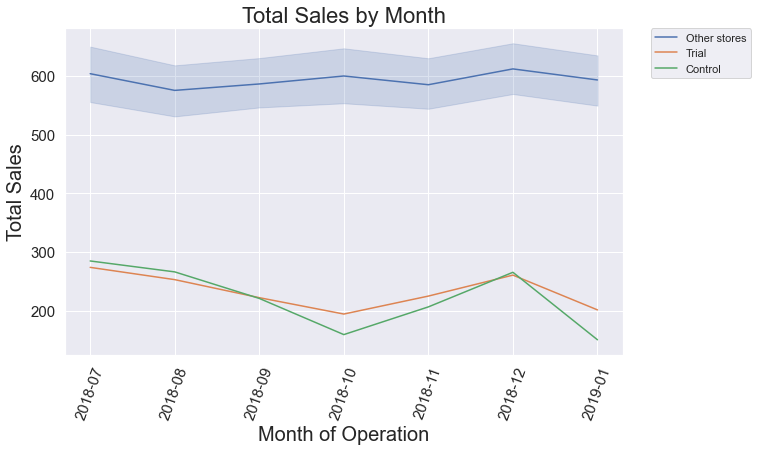

In [20]:
plot_total_sales_by_month(pre_trial)

#### Plot Number of Customers by Month in Pre-Trial Period

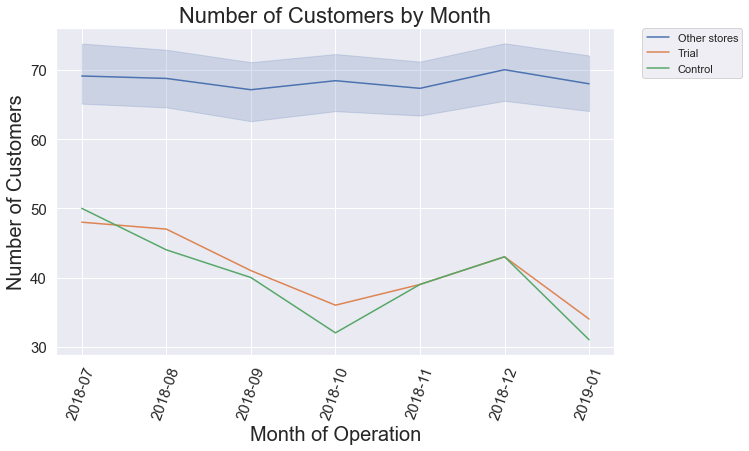

In [21]:
plot_number_of_customers_by_month(pre_trial)

Both graphs confirm that the totals sales and number of customers per month for the control store is similar to the trial store in the pre-trial period.

### Assessment of Total Sales for Trial Store 77 in the Trial Period

#### T-Value Statistic Based On Pre-Trial Period 

In [22]:
# There are seven months in the pre-trial period so the degrees of freedom are 7 - 1 = 6
p = 0.95
df = 6
t_dist_value = t.ppf(p, df)
t_dist_value

1.9431802803927816

#### Determine if Percentage Difference Between the Control and Trial Total Sales is Statistically Significant

The t-values for March and April are higher than the expected value for a t-distribution with 6 degrees of freedom. Therefore, the higher relative sales for the trial store appear significant.

In [23]:
scale_control_sales = scale_control_metric(pre_trial_measures,
                                           measure_over_time,
                                           trial_store,
                                           control_store,
                                           'Tot_Sales')
perc_diff = calculate_perc_diff(scale_control_sales,
                                measure_over_time,
                                trial_store,
                                'Tot_Sales')
std_dev, u = calculate_std_dev_mean(perc_diff)
t_values = calculate_t_values(perc_diff, std_dev, u)
t_values

,YEARMONTH,Control_Metric,Trial_Metric,Percent_Diff,T-Value
0,2018-07,298.757223,273.8,0.087178,0.809929
1,2018-08,279.238837,252.9,0.098992,0.899889
2,2018-09,231.807062,222.2,0.042321,0.468367
3,2018-10,167.165527,194.3,-0.150136,0.997095
4,2018-11,216.696054,224.9,-0.037156,0.136810
5,2018-12,278.504274,260.6,0.066422,0.651885
6,2019-01,157.931022,201.4,-0.241944,1.696166
7,2019-02,239.992191,222.2,0.076990,0.732356
8,2019-03,189.517227,255.1,-0.295008,2.100220
9,2019-04,151.319956,263.5,-0.540861,3.972269


#### Plot Total Sales by Month for the Trial Store, Control Store and the Control Store's 5th and 95th Percentile

The graph below shows that sales for the trial store deviated significantly from the control store during the months of March and April. The increased sales for the trial store were also significantly higher than the 95% confidence interval for the control store. It should also be noted that the total sales for store 77 in the month of January is slightly outside the control stores confidence interval. However, the t-value above for this month was not considered significant and January is also outside the trial period.

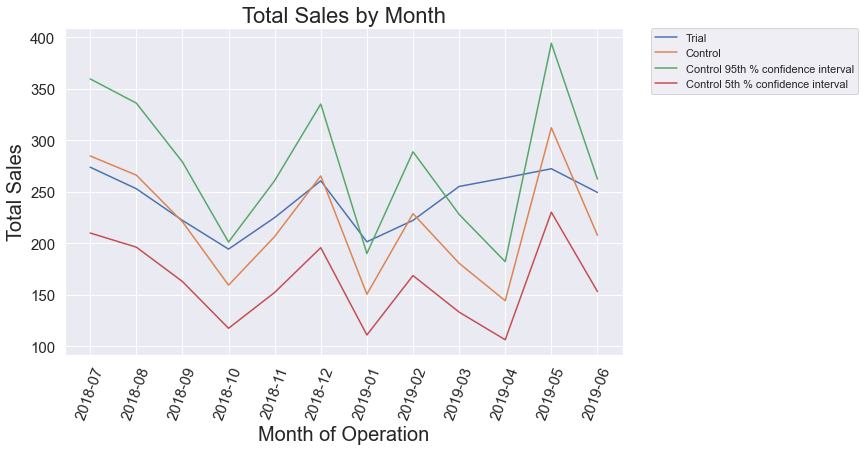

In [24]:
all_months = create_control_trial_dataframe(measure_over_time,
                                            trial_store,
                                            control_store)
trialAssessment = control_conf_int(all_months, 'Tot_Sales')
plot_total_sales_by_month(trialAssessment)

### Assessment of Number of Customers for Trial Store 77 in the Trial Period

#### T-Value Statistic Based On Pre-Trial Period 

In [25]:
t_dist_value

1.9431802803927816

#### Determine if Percentage Difference Between the Control and Trial Customer Numbers is Statistically Significant

The t-values for March and April are higher than the expected value for a t-distribution with 6 degrees of freedom.

In [26]:
scale_control_num_cust = scale_control_metric(pre_trial_measures,
                                           measure_over_time,
                                           trial_store,
                                           control_store,
                                           'Number_Customers')
perc_diff = calculate_perc_diff(scale_control_num_cust,
                                measure_over_time,
                                trial_store,
                                'Number_Customers')
std_dev, u = calculate_std_dev_mean(perc_diff)
t_values = calculate_t_values(perc_diff, std_dev, u)
t_values

,YEARMONTH,Control_Metric,Trial_Metric,Percent_Diff,T-Value
0,2018-07,51.612903,48,0.072539,1.371833
1,2018-08,45.419355,47,-0.034206,0.507347
2,2018-09,41.290323,41,0.007056,0.219046
3,2018-10,33.032258,36,-0.085981,1.418823
4,2018-11,40.258065,39,0.031746,0.653699
5,2018-12,44.387097,43,0.031746,0.653699
6,2019-01,32.000000,34,-0.060606,0.972106
7,2019-02,44.387097,43,0.031746,0.653699
8,2019-03,36.129032,46,-0.240377,4.136870
9,2019-04,27.870968,47,-0.510987,8.900795


#### Plot Number of Customers by Month for the Trial Store, Control Store and the Control Store's 5th and 95th Percentile

The graph below shows that the number of customers for the trial store deviated significantly from the control store during the months of March and April. The increased number of customers for the trial store were also significantly higher than the 95% confidence interval for the control store.

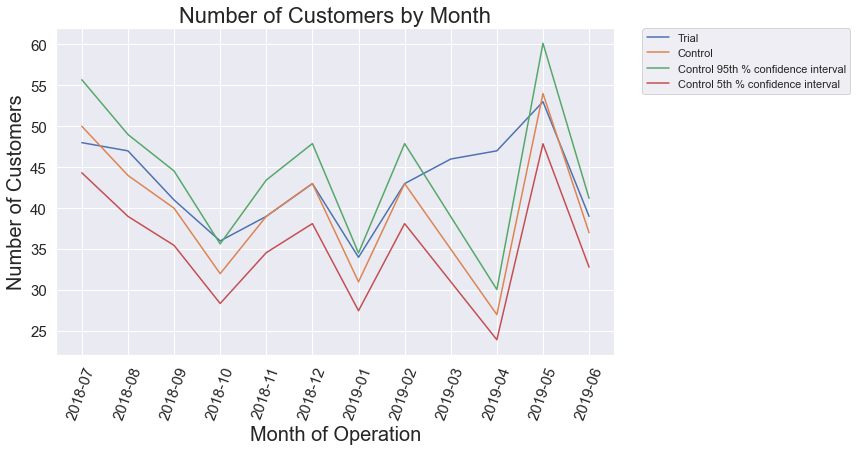

In [27]:
all_months = create_control_trial_dataframe(measure_over_time,
                                            trial_store,
                                            control_store)
trialAssessment = control_conf_int(all_months, 'Number_Customers')
plot_number_of_customers_by_month(trialAssessment)

## Analysis for Trial Store 86

### Select Control Store and Compare Total Sales and Number of Customers in Pre-Trial Period

#### Find the Most Similar Store to Trial Store 86

In [28]:
trial_store = 86
corr_sales = calculate_correlation(pre_trial_measures,
                                   'Tot_Sales',
                                   trial_store)
corr_customers = calculate_correlation(pre_trial_measures,
                                       'Number_Customers',
                                       trial_store)
std_dist_sales = calculate_magnitude_distance(pre_trial_measures,
                                              'Tot_Sales',
                                              trial_store)
std_dist_customers = calculate_magnitude_distance(pre_trial_measures,
                                                  'Number_Customers',
                                                  trial_store)
corr_weight = 0.5
control_store = best_control_store(corr_sales,
                                   corr_customers,
                                   std_dist_sales,
                                   std_dist_customers,
                                   corr_weight)
control_store

155

#### Create Dataframe and Variable for Plots

In [29]:
trial_begin = '2019-02'
pre_trial = add_store_type(pre_trial_measures,
                           trial_begin,
                           trial_store,
                           control_store)
pre_trial['YEARMONTH'] = pre_trial['YEARMONTH'].astype(str)

#### Plot Total Sales by Month in Pre-Trial Period

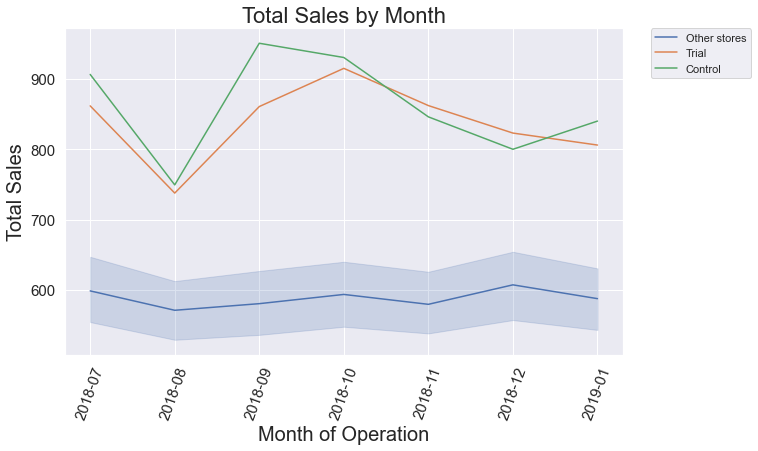

In [30]:
plot_total_sales_by_month(pre_trial)

#### Plot Number of Customers by Month in Pre-Trial Period

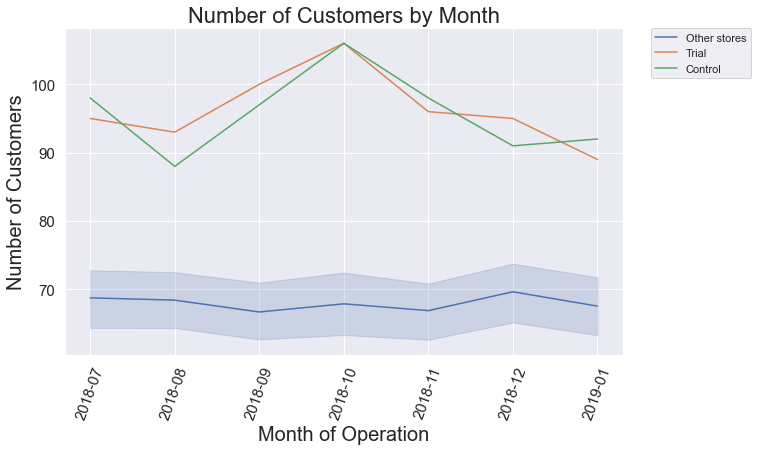

In [31]:
plot_number_of_customers_by_month(pre_trial)

Both graphs confirm that the totals sales and number of customers per month for the control store is similar to the trial store in the pre-trial period.

### Assessment of Total Sales for Trial Store 86 in the Trial Period

#### T-Value Statistic Based On Pre-Trial Period 

In [32]:
t_dist_value

1.9431802803927816

#### Determine if Percentage Difference Between the Control and Trial Total Sales is Statistically Significant

The t-values show a significance difference in the month of March only.

In [33]:
scale_control_sales = scale_control_metric(pre_trial_measures,
                                           measure_over_time,
                                           trial_store,
                                           control_store,
                                           'Tot_Sales')
perc_diff = calculate_perc_diff(scale_control_sales,
                                measure_over_time,
                                trial_store,
                                'Tot_Sales')
std_dev, u = calculate_std_dev_mean(perc_diff)
t_values = calculate_t_values(perc_diff, std_dev, u)
t_values

,YEARMONTH,Control_Metric,Trial_Metric,Percent_Diff,T-Value
0,2018-07,882.458054,861.40,0.024151,0.581625
1,2018-08,729.829824,737.65,-0.010658,0.219026
2,2018-09,925.509540,860.40,0.072915,1.703246
3,2018-10,905.834427,914.60,-0.009630,0.195386
4,2018-11,823.822321,861.80,-0.045061,1.010331
5,2018-12,779.017607,822.80,-0.054666,1.231262
6,2019-01,817.978228,805.80,0.015000,0.371135
7,2019-02,844.276646,888.80,-0.051381,1.155699
8,2019-03,762.459343,961.20,-0.230603,5.278032
9,2019-04,789.731778,814.40,-0.030756,0.681302


#### Plot Total Sales by Month for the Trial Store, Control Store and the Control Store's 5th and 95th Percentile

In the trial period, there is only a significant increase of sales in March for the trial store. All other months are similar to the control store.

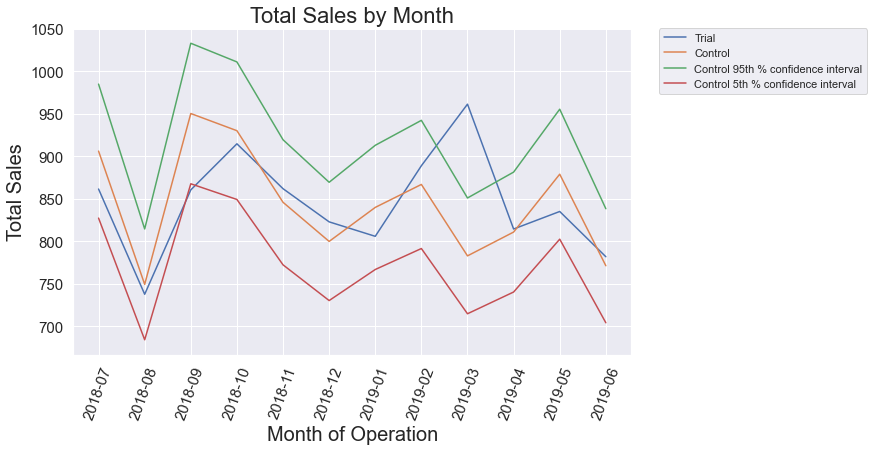

In [34]:
all_months = create_control_trial_dataframe(measure_over_time,
                                            trial_store,
                                            control_store)
trialAssessment = control_conf_int(all_months, 'Tot_Sales')
plot_total_sales_by_month(trialAssessment)

### Assessment of Number of Customers for Trial Store 86 in the Trial Period

#### T-Value Statistic Based On Pre-Trial Period 

In [35]:
t_dist_value

1.9431802803927816

#### Determine if Percentage Difference Between the Control and Trial Customer Numbers is Statistically Significant

The t-values for the months of February and March show a significance increase of customers for the trial store.

In [36]:
scale_control_num_cust = scale_control_metric(pre_trial_measures,
                                           measure_over_time,
                                           trial_store,
                                           control_store,
                                           'Number_Customers')
perc_diff = calculate_perc_diff(scale_control_num_cust,
                                measure_over_time,
                                trial_store,
                                'Number_Customers')
std_dev, u = calculate_std_dev_mean(perc_diff)
t_values = calculate_t_values(perc_diff, std_dev, u)
t_values

,YEARMONTH,Control_Metric,Trial_Metric,Percent_Diff,T-Value
0,2018-07,98.585075,95,0.037039,1.020056
1,2018-08,88.525373,93,-0.049300,1.337683
2,2018-09,97.579104,100,-0.024506,0.660591
3,2018-10,106.632836,106,0.005952,0.171152
4,2018-11,98.585075,96,0.026570,0.734179
5,2018-12,91.543284,95,-0.037061,1.003446
6,2019-01,92.549254,89,0.039100,1.076334
7,2019-02,94.561194,106,-0.114068,3.106353
8,2019-03,92.549254,110,-0.172311,4.696851
9,2019-04,95.567164,101,-0.055277,1.500898


#### Plot Number of Customers by Month for the Trial Store, Control Store and the Control Store's 5th and 95th Percentile

For February, there was a significant increase of customers for the trial store although this was not reflected in the total sales for the same month. The increased number of customers for March was also outside the 95th percentage confidence interval as was the case for the total sales in that month.

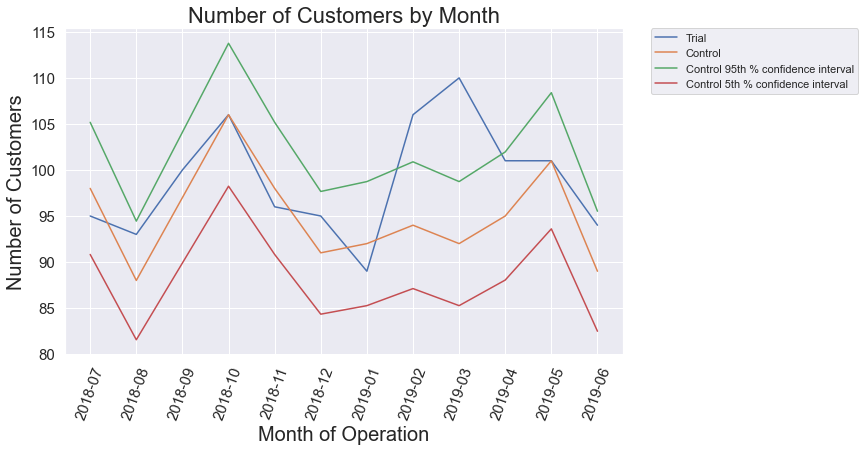

In [37]:
all_months = create_control_trial_dataframe(measure_over_time,
                                            trial_store,
                                            control_store)
trialAssessment = control_conf_int(all_months, 'Number_Customers')
plot_number_of_customers_by_month(trialAssessment)

## Analysis for Trial Store 88

### Select Contol Store and Compare Total Sales and Number of Customers in Pre-Trial Period

#### Find the Most Similar Store to Trial Store 88

In [38]:
trial_store = 88
corr_sales = calculate_correlation(pre_trial_measures,
                                   'Tot_Sales',
                                   trial_store)
corr_customers = calculate_correlation(pre_trial_measures,
                                       'Number_Customers',
                                       trial_store)
std_dist_sales = calculate_magnitude_distance(pre_trial_measures,
                                              'Tot_Sales',
                                              trial_store)
std_dist_customers = calculate_magnitude_distance(pre_trial_measures,
                                                  'Number_Customers',
                                                  trial_store)
corr_weight = 0.5
control_store = best_control_store(corr_sales,
                                   corr_customers,
                                   std_dist_sales,
                                   std_dist_customers,
                                   corr_weight)
control_store

237

#### Create Dataframe and Variable for Plots

In [39]:
trial_begin = '2019-02'
pre_trial = add_store_type(pre_trial_measures,
                           trial_begin,
                           trial_store,
                           control_store)
pre_trial['YEARMONTH'] = pre_trial['YEARMONTH'].astype(str)

#### Plot Total Sales by Month in Pre-Trial Period

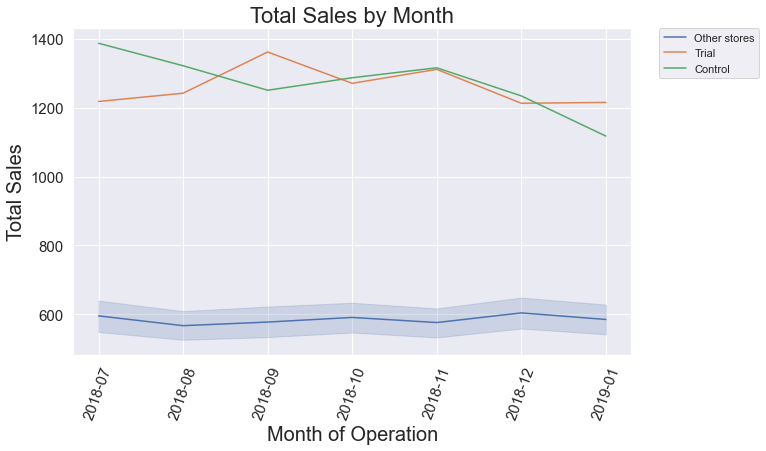

In [40]:
plot_total_sales_by_month(pre_trial)

#### Plot Number of Customers by Month in Pre-Trial Period

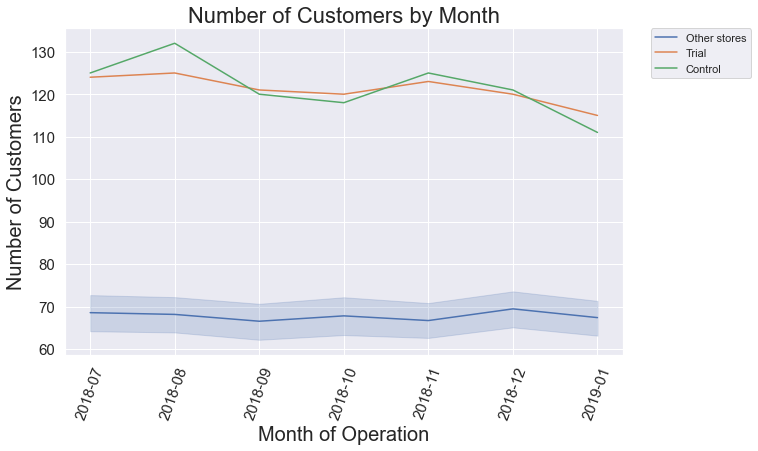

In [41]:
plot_number_of_customers_by_month(pre_trial)

Both graphs confirm that the totals sales and number of customers per month for the control store are similar to the trial store in the pre-trial period.

### Assessment of Total Sales for Trial Store 88 in the Trial Period

#### T-Value Statistic Based On Pre-Trial Period 

In [42]:
t_dist_value

1.9431802803927816

#### Determine if Percentage Difference Between the Control and Trial Total Sales is Statistically Significant

The t-values show a significance difference in the month of March only.

In [43]:
scale_control_sales = scale_control_metric(pre_trial_measures,
                                           measure_over_time,
                                           trial_store,
                                           control_store,
                                           'Tot_Sales')
perc_diff = calculate_perc_diff(scale_control_sales,
                                measure_over_time,
                                trial_store,
                                'Tot_Sales')
std_dev, u = calculate_std_dev_mean(perc_diff)
t_values = calculate_t_values(perc_diff, std_dev, u)
t_values

,YEARMONTH,Control_Metric,Trial_Metric,Percent_Diff,T-Value
0,2018-07,1374.394024,1218.20,0.120492,1.593592
1,2018-08,1309.696842,1242.20,0.052899,0.707958
2,2018-09,1239.253204,1361.80,-0.094229,1.219775
3,2018-10,1275.218100,1270.80,0.003471,0.060321
4,2018-11,1303.851308,1311.40,-0.005773,0.060790
5,2018-12,1223.004601,1213.00,0.008214,0.122471
6,2019-01,1107.381921,1215.40,-0.093008,1.203776
7,2019-02,1300.879003,1339.60,-0.029329,0.369430
8,2019-03,1166.728952,1467.00,-0.228020,2.972763
9,2019-04,1142.950509,1317.00,-0.141506,1.839230


#### Plot Total Sales by Month for the Trial Store, Control Store and the Control Store's 5th and 95th Percentile

The plot confirms the t-value result showing total sales were only significantly higher in March. There is also a noticeable difference between the trial and control store in April. However, the trial stores total sales are still within the confidence interval of the control store.

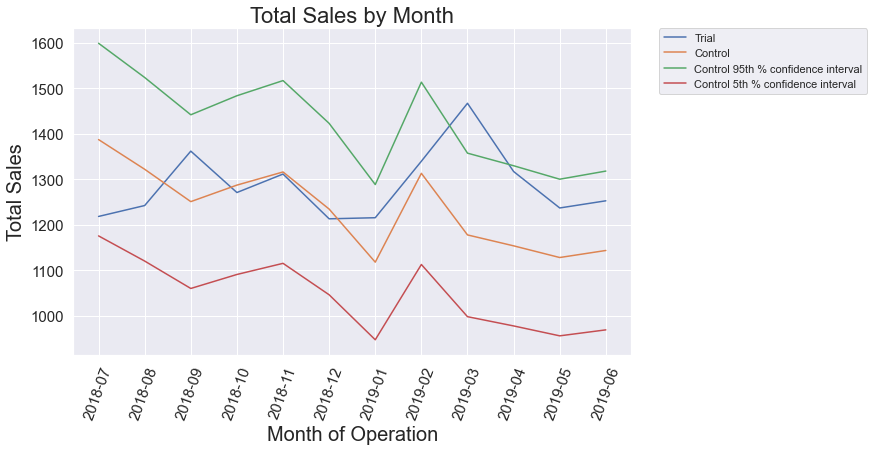

In [44]:
all_months = create_control_trial_dataframe(measure_over_time,
                                            trial_store,
                                            control_store)
trialAssessment = control_conf_int(all_months, 'Tot_Sales')
plot_total_sales_by_month(trialAssessment)

### Assessment of Number of Customers for Trial Store 88 in the Trial Period

#### T-Value Statistic Based On Pre-Trial Period 

In [45]:
t_dist_value

1.9431802803927816

#### Determine if Percentage Difference Between the Control and Trial Customer Numbers is Statistically Significant

Like with the monthly total sales, there is only a significant difference in March.

In [46]:
scale_control_num_cust = scale_control_metric(pre_trial_measures,
                                           measure_over_time,
                                           trial_store,
                                           control_store,
                                           'Number_Customers')
perc_diff = calculate_perc_diff(scale_control_num_cust,
                                measure_over_time,
                                trial_store,
                                'Number_Customers')
std_dev, u = calculate_std_dev_mean(perc_diff)
t_values = calculate_t_values(perc_diff, std_dev, u)
t_values

,YEARMONTH,Control_Metric,Trial_Metric,Percent_Diff,T-Value
0,2018-07,124.413146,124,0.003326,0.149434
1,2018-08,131.380282,125,0.049772,1.780403
2,2018-09,119.436620,121,-0.013005,0.424031
3,2018-10,117.446009,120,-0.021512,0.722782
4,2018-11,124.413146,123,0.011423,0.433768
5,2018-12,120.431925,120,0.003593,0.158797
6,2019-01,110.478873,115,-0.040102,1.375590
7,2019-02,118.441315,122,-0.029601,1.006836
8,2019-03,115.455399,133,-0.141229,4.926720
9,2019-04,115.455399,119,-0.030237,1.029155


#### Plot Number of Customers by Month for the Trial Store, Control Store and the Control Store's 5th and 95th Percentile

The plot also shows that there was only a significant difference in the number of customers in March.

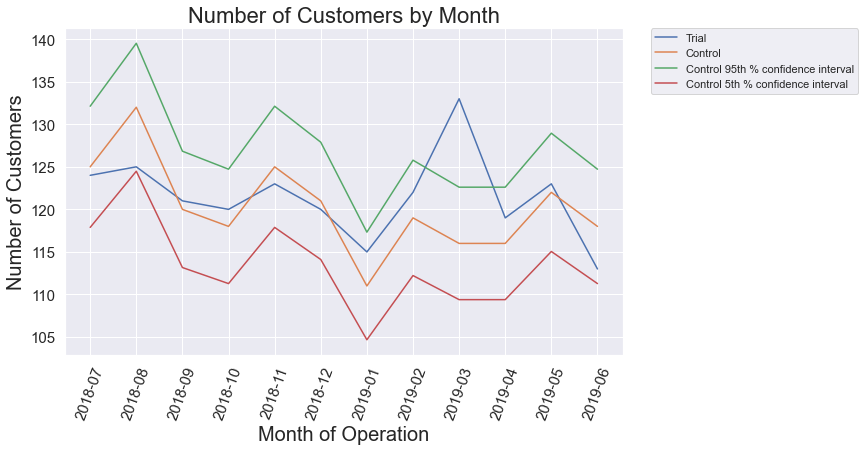

In [47]:
all_months = create_control_trial_dataframe(measure_over_time,
                                            trial_store,
                                            control_store)
trialAssessment = control_conf_int(all_months, 'Number_Customers')
plot_number_of_customers_by_month(trialAssessment)

## Conclusion

There appears to be evidence that the trial layout of a new chips category has had some impact on total sales and increased patronage for the trial stores. However, the level of success is varied across the three trial stores.

Store 77 had the greatest improvement. In the trial period, two of the three months resulted in significant increases for total sales and the number of customers for this store. For store 86, there was only a significant increase in total sales in March. This was also reflected by a significant increase in the number of customers in the same month. Curiously, store 86 also had a significant increase in the number of customers in February. However, the increases in total sales for that month, although higher than the control store, were not found to be significant. Finally, store 88 saw significant increases for total sales and number of customers only in the month of March.

Although, all trial stores recorded improvements in total sales and number of customers from the promotion, there was no clear evidence of this until the second month of the trial period. For stores 86 and 88, the increases only lasted for one month during the trial period. Store 77 not only continued with significant increases into April but also further improved on March when the sales and number of customers for the control store where declining over the same time.

The promotion in the trial stores overall can be considered a success. However, some changes may need to be made to sustain the increased sales and number of customers for longer than a month. This problem was clearly evident for stores 86 and 88.